# Resizing an image in Programmable Logic
This reference design illustrates how to run a resizer IP on the FPGA(PL) using Jupyter Notebooks and Python

## Block diagram:

![](./images/resize_bd.png)

## Contents    
  

* [Resizing an image in Programmable Logic](#Resizing-an-image-in-Programmable-Logic)
    * [Import libraries](#Import-libraries)
    * [Download the Resize IP bitstream](#Download-the-Resize-IP-bitstream)
    * [Create an Image object using PIL in SW](#Create-an-Image-object-using-PIL-in-SW)
    * [Display the image to be resized](#Display-the-image-to-be-resized)
    * [Resizing in Software](#Resizing-in-Software)
    * [Resize in Programmable Logic](#Resize-in-Programmable-Logic)
* [References](#References)

## Import libraries

In [2]:
from PIL import Image
import numpy as np
from IPython.display import display, Markdown
from pynq import Xlnk
from pynq import Overlay


## Download the Resize IP bitstream

In [3]:
resize_design = Overlay("bitstream/resize.bit")

#### Create DMA and Resizer IP objects

In [4]:
dma = resize_design.axi_dma_0
resizer = resize_design.resize_accel_0

## Create an Image object using PIL in SW
#### Load image from the SD card and create an Image object

In [5]:
image_path = "./images/paris.jpg"
original_image = Image.open(image_path)
original_image.load()

#### Create a numpy array of the pixels

In [6]:
input_array = np.array(original_image)

## Display the image to be resized

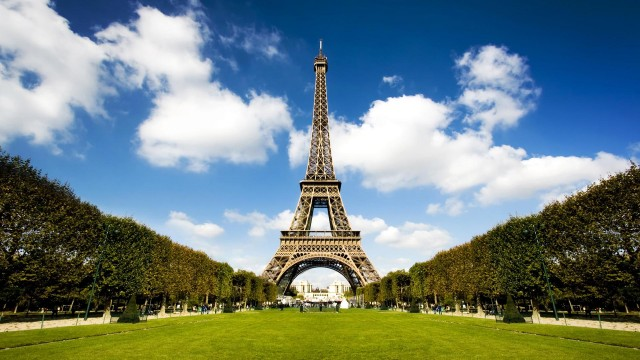

In [7]:
input_image = Image.fromarray(input_array)
display(input_image)

def printmd(string):
    display(Markdown('<h1 style="color:DeepPink"> {}</h1>'.format(string)))

#### Original image size

In [8]:
old_width, old_height = original_image.size
printmd("Image size: {}x{} pixels.".format(old_width, old_height))

<h1 style="color:DeepPink"> Image size: 640x360 pixels.</h1>

## Resizing in Software

#### Setting image resize dimensions
**Note:** Downscale factor range:  1 to 7 (by design of the resize IP)

In [9]:
resize_factor = 2
new_width, new_height = int(old_width/resize_factor), int(old_height/resize_factor)

#### Timing in SW

In [10]:
%%timeit
resized_image_sw = original_image.resize((new_width, new_height), Image.BILINEAR)

30.6 ms ± 35.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Using resize() method from the PIL library

In [11]:
resized_image_sw = original_image.resize((new_width, new_height), Image.BILINEAR)

#### Display resized image

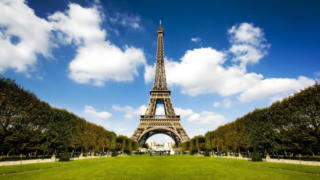

In [12]:
output_array_sw = np.array(resized_image_sw)
result_sw = Image.fromarray(output_array_sw)
display(result_sw)

#### Resized image size

In [13]:
width_sw, height_sw = resized_image_sw.size
printmd("Image size resized in SW: {}x{} pixels.".format(width_sw, height_sw))

<h1 style="color:DeepPink"> Image size resized in SW: 320x180 pixels.</h1>

## Resize in Programmable Logic

#### Allocating memory to process data on PL
Data is provided through contiguous memory locations.

The size of the buffer depends on the size of the input or output data.
The image dimensions extracted from the read image are used to allocate contiguous memory as follows.
We will use `cma_array` of the corresponding size.

In [14]:
xlnk = Xlnk()
in_buffer = xlnk.cma_array(shape=(old_height, old_width, 3), dtype=np.uint8, cacheable=1)
out_buffer = xlnk.cma_array(shape=(new_height, new_width, 3), dtype=np.uint8, cacheable=1)

__Note: In the following example, we are only dealing with one image. We will just send one image to the kernel and obtain the results.__

__Also Note: The `input_array` has to be copied into the contiguous memory array(deep copy).__

#### Display the image in buffer

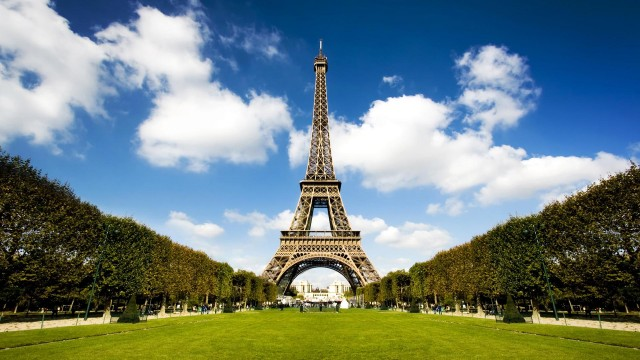

<h1 style="color:DeepPink"> Image size: 640x360 pixels.</h1>

In [15]:
in_buffer[:] = input_array
buf_image = Image.fromarray(in_buffer)
display(buf_image)
printmd("Image size: {}x{} pixels.".format(old_width, old_height))


#### Run the Resizer IP
Now we will push the data from input buffer through the pipeline to the output buffer.   
Providing scalar inputs and running the kernel

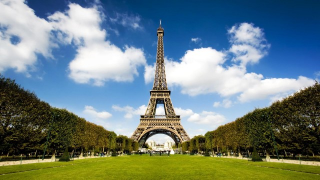

<h1 style="color:DeepPink"> Resized in Hardware(PL): 320x180 pixels.</h1>

In [16]:
resizer.write(0x10, old_height) # src rows
resizer.write(0x18, old_width)  # src cols
resizer.write(0x20, new_height) # dst rows
resizer.write(0x28, new_width)  # dst cols

def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)
    resizer.write(0x00,0x81)
    dma.sendchannel.wait()
    dma.recvchannel.wait()

run_kernel()

result = Image.fromarray(out_buffer)
display(result)
printmd("Resized in Hardware(PL): {}x{} pixels.".format(new_width, new_height))

#### Timing in HW

In [17]:
%%timeit

resizer.write(0x10, old_height) # src rows
resizer.write(0x18, old_width)  # src cols
resizer.write(0x20, new_height) # dst rows
resizer.write(0x28, new_width)  # dst cols

def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)
    resizer.write(0x00,0x81)
    dma.sendchannel.wait()
    dma.recvchannel.wait()

run_kernel()

4.16 ms ± 2.35 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Reset Xlnk

In [18]:
xlnk.xlnk_reset()

[Back to Contents](#Contents)

# References

https://pillow.readthedocs.io/en/3.1.x/index.html   
https://github.com/Xilinx/PYNQ/blob/master/docs/source/python_environment.ipynb   
https://github.com/Xilinx/PYNQ/blob/master/docs/source/jupyter_notebooks.ipynb   
https://github.com/Xilinx/PYNQ/blob/master/docs/source/jupyter_notebooks_advanced_features.ipynb   